<a href="https://colab.research.google.com/github/JawadMM/dog-breed-identification/blob/main/dog_breed_identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

Given a picture of a dog, we want to know the breed of that dog.

## 2. Data

The data used in this notebook is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilitites for each dog breed of each test image

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* The data is in form of images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are 10,222 images in the training set (these images have labels).
* There are 10,357 images in the testing set (these images have no labels).

### Getting the work space ready

In [1]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
%load_ext tensorboard

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split

import os
from IPython.display import Image

import datetime

# Check for GPU availablity
print("GPU available" if tf.config.list_physical_devices("GPU") else "GPU not available")

GPU available


## Getting the data ready (turning it into Tensors)

 The data has to be in numerical format. Therefore, the images has to be turned into Tensors (numerical representation).

In [2]:
labels_csv = pd.read_csv("drive/MyDrive/Dog Breed Identifier/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: xlabel='breed'>

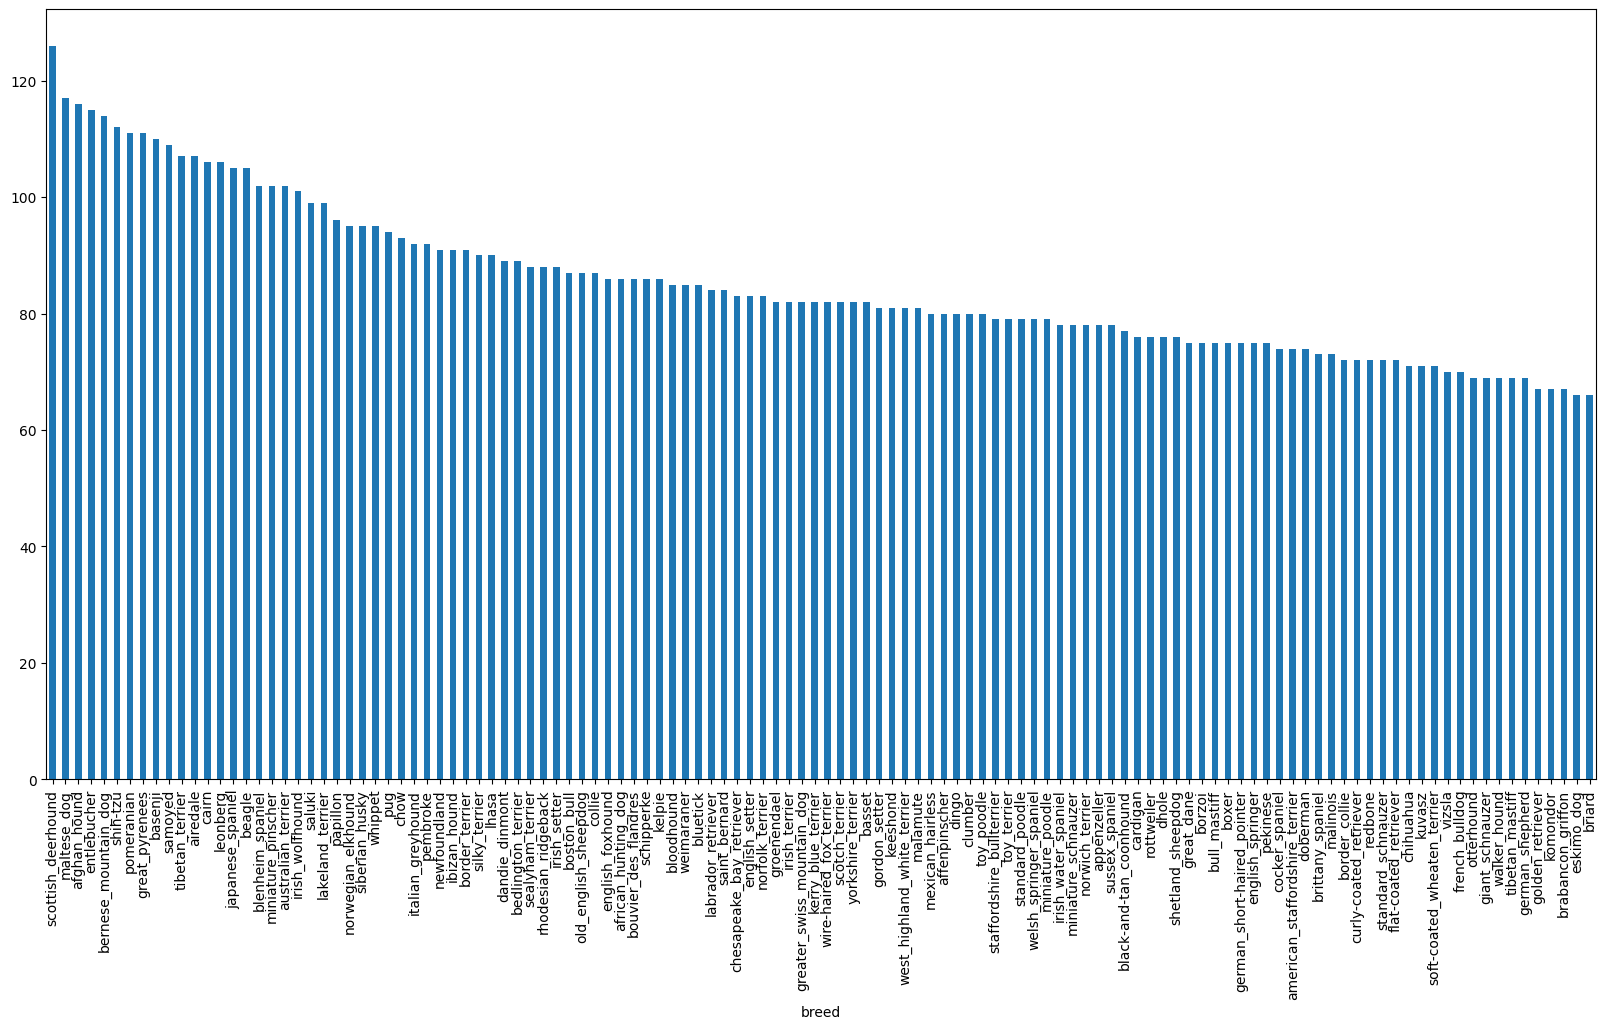

In [3]:
# The number of images for each breed
labels_csv["breed"].value_counts().plot.bar(figsize = (20, 10))

In [4]:
#print(labels_csv.breed.value_counts())
print(f"The average number of images per class: {labels_csv.breed.value_counts().mean()}")
print(f"The median of the number images per class: {labels_csv.breed.value_counts().median()}")

The average number of images per class: 85.18333333333334
The median of the number images per class: 82.0


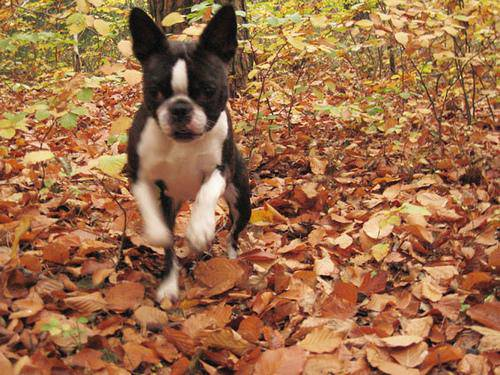

In [5]:
Image("drive/MyDrive/Dog Breed Identifier/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

In [6]:
# Create pathnames from image ID's
image_paths = ["drive/MyDrive/Dog Breed Identifier/train/" + img_id + ".jpg" for img_id in labels_csv["id"]]

# Check the first 5
image_paths[:5]

['drive/MyDrive/Dog Breed Identifier/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Breed Identifier/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Breed Identifier/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Breed Identifier/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Breed Identifier/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [7]:
# Check whther the number of image_paths matches the number of actual image files to avoid potential issues later
# print(len(image_paths))
if (len(os.listdir("drive/MyDrive/Dog Breed Identifier/train/")) == len(image_paths)):
  print("Image_paths match the actual amount of files.")
else:
  print("Image_paths do not match the actual amount of files.")

Image_paths match the actual amount of files.


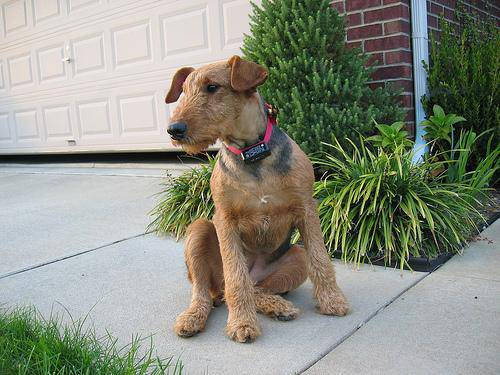

In [8]:
# checke that the path of each image is in the correct format
Image(image_paths[8032])

### Preparing the labels

In [9]:
labels = labels_csv["breed"].to_numpy()
# label
print(len(labels))

10222


In [10]:
# Check whther the number of labels matches the number of paths
if (len(labels) == len(image_paths)):
  print("The naumber of labels match the number of paths.")
else:
  print("The naumber of labels do not match the number of paths.")

The naumber of labels match the number of paths.


In [11]:
# Find the unique label values
unique_breeds = np.unique(labels)
# unique_breeds
len(unique_breeds)

120

In [12]:
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [13]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
# boolean_labels
# len(boolean_labels)
boolean_labels[0].astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Creating validation set
Since the dataset from Kaggle does not come with a validation set, the training set has to be split in order to train the model.

In [14]:
# Setup X & y variables
X = image_paths
y = boolean_labels

This experiment will start off with 1000 images and increase as needed.

In [15]:
# Set the number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min: 1000, max: 10000}

In [16]:
# Split the data into train and validation sets of total size of NUM_IMAGES

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state = 42)

# Checking the size of the data
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [17]:
# X_train[:2], y_train[:2]

## Preprocessing Images (turning images into Tensors)

A function will be needed to process the images into Tensors.

The function will do few things:
1. Take an image filepath as input.
2. Use TensorFlow to read the file and save it to a variable, `image`.
3. Turn the `image` variable (a jpg) into Tensors.
4. Normalize the `image` by converting color channel values from [0 - 255] to [0 - 1].
6. Resize the `image` to be a shape of (224, 224).
6. Return the modified `image`.

Checking how the Tensor looks like.

In [18]:
# Conver image to NumPy array
# image = imread(image_paths[0])
# print(image.shape)

# Turn image into Tensor
# tf.constant(image)

In [19]:
# tensor = tf.io.read_file(image_paths[0])
# tensor = tf.image.decode_jpeg(tensor, channels = 3)
# tensor = tf.image.convert_image_dtype(tensor, tf.float32)
# tensor

In [20]:
# Define the size of the image
IMG_SIZE = 224

# Create a function for preprossecing images
def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read the image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels = 3)
  # Conver the color channel values from [0 - 255] to [0 - 1] values (for efficency and speed up the the learning process)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to (244, 244)
  image = tf.image.resize(image, size = [img_size, img_size])

  return image

## Turning the data into batches

To avoid running out of memory, it is important to take a smull portion of the data at a time to process it.

In order to use TensorFlow effectively, the data has to be in the form of Tensor tuples `(image, label)`.

In [21]:
# Create a function that returns a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [22]:
# Define the batch size
BATCH_SIZE = 32

# Create a funtion that turns data into batches
def create_data_batches(X, y = None, batch_size = BATCH_SIZE, val_data = False, test_data = False):
  """
  Creates batches of data out if image (x) and label (y) pairs.
  Shuffles the data if it is training data but does not shuffle if it is validation data.
  Accepts test data as input (no labels).
  """
  # If the data is a test dataset, it means there are no labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  # If the data is a validation dataset there is no need to shuffle it.
  elif val_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # file paths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn file paths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # file paths
                                               tf.constant(y))) # labels
    # Shuffle the data before mapping the image processor function (it is fater to shuffle before processing because the filepaths are in the form of strings)
    data = data.shuffle(buffer_size = len(X))
    # Create (image, label) tuples
    data = data.map(get_image_label)
    # Turn the training data into batches
    data_batch = data.batch(batch_size)
    return data_batch

In [23]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, val_data = True)

Creating training data batches...
Creating validation data batches...


In [24]:
train_data.element_spec, val_data.element_spec #None represent the batch size. It is represented by None because the batch size is flexible

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

In [25]:
# Create a function for viewing images in a data batch
def show_images(images, labels, num_imgs = 25):
  """
  Displays a plot of images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize = (10, 10))
  # Loop through the number of images
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i + 1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the gridlines off
    plt.axis("off")

In [26]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

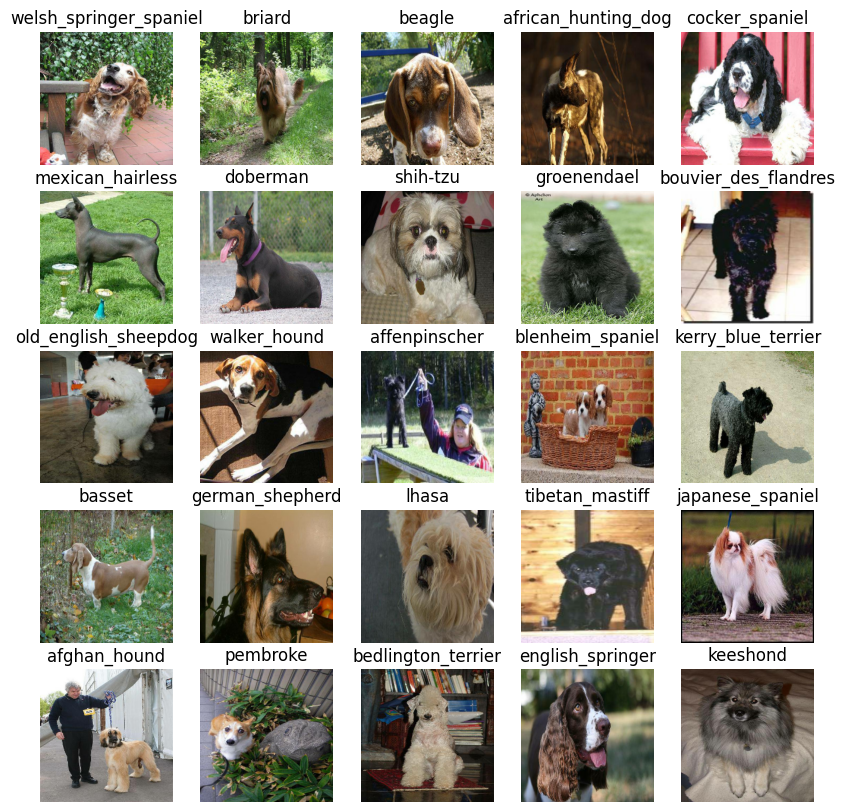

In [27]:
show_images(train_images, train_labels)

## Building a model

In [28]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup outout shape to the model
OUTPUT_SHAPE = len(unique_breeds) # number of classes (120 unique breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1"

In [29]:
# Create a function that builds a Keras model
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("building model with:", model_url)

  # Setup the model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(model_url), # input layer
      tf.keras.layers.Dense(units = output_shape,
                            activation = "softmax") # output layer
  ])

  # Compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [30]:
model = create_model()
model.summary()

building model with: https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating callbacks

Using callbacks for the model to use during training in order to save and check its progress oe stop training early if the model stops improving.



### 1. TensorBoard Callback
TensorBoard helps track the model progress.

In [31]:
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Dog Breed Identifier/logs",
                        # Make it so the logs get tracked whenever the experiment is ran
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### 2. Early Stopping callback
 Early Stopping helps to prevent overfitting

In [32]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 3)

## Training a model (on subset of the data)


In [33]:
NUM_EPOCHS = 100 #@param {type:"slider", min: 10, max: 100, step: 10}

In [34]:
# Create a function that trains the model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime a model is trained
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data and passing it the callbacks we created
  model.fit(x = train_data,
            epochs = NUM_EPOCHS,
            validation_data = val_data,
            validation_freq = 1,
            callbacks = [tensorboard, early_stopping])

  return model

In [35]:
# Fit the model to the data
model = train_model()

building model with: https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1
Epoch 1/100
25/25 [==============================] - 222s 9s/step - loss: 4.5992 - accuracy: 0.0812 - val_loss: 3.4045 - val_accuracy: 0.2550
Epoch 2/100
25/25 [==============================] - 5s 186ms/step - loss: 1.6258 - accuracy: 0.6775 - val_loss: 2.1301 - val_accuracy: 0.5100
Epoch 3/100
25/25 [==============================] - 5s 198ms/step - loss: 0.5507 - accuracy: 0.9463 - val_loss: 1.6846 - val_accuracy: 0.5700
Epoch 4/100
25/25 [==============================] - 8s 337ms/step - loss: 0.2479 - accuracy: 0.9900 - val_loss: 1.5051 - val_accuracy: 0.6050
Epoch 5/100
25/25 [==============================] - 7s 260ms/step - loss: 0.1476 - accuracy: 0.9962 - val_loss: 1.4359 - val_accuracy: 0.6200
Epoch 6/100
25/25 [==============================] - 7s 272ms/step - loss: 0.1007 - accuracy: 0.9987 - val_loss: 1.3900 - val_accuracy: 0.6250
Epoch 7/100
25/25 [====================

**It looks like the model is overfitting since the accuracy on the training set is far higher than the accuracy on the validation set.**

## Making and evaluating preditions using the trained model

In [36]:
# Make predictions on the validation data
predictions = model.predict(val_data, verbose = 1)
predictions

7/7 [==============================] - 2s 155ms/step


array([[1.45409198e-03, 5.11741491e-05, 1.84421020e-03, ...,
        2.91155011e-04, 4.00618846e-05, 1.98303047e-03],
       [2.14852975e-03, 2.11828097e-04, 1.50993536e-03, ...,
        6.49998779e-04, 6.13034994e-04, 7.10642489e-05],
       [1.38275220e-06, 2.88908686e-05, 2.68338827e-05, ...,
        1.14596471e-04, 3.60766626e-06, 1.45430080e-04],
       ...,
       [2.27610911e-07, 5.62169498e-06, 8.82299282e-05, ...,
        4.46019976e-06, 1.21472385e-05, 3.51434846e-06],
       [1.34291714e-02, 3.63152678e-04, 5.14546991e-04, ...,
        9.34728305e-05, 7.48374805e-05, 4.95589674e-02],
       [4.42926743e-04, 9.45863667e-06, 1.67004543e-03, ...,
        5.38639957e-03, 1.98954972e-03, 2.39384208e-05]], dtype=float32)

In [37]:
# First prediction
index = 0
print(predictions[index])
print(f"Max value (probability of the prediction: {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])})")
print(f"Max index: {np.argmax(predictions[index])})")
print(f"Prediction Label: {unique_breeds[np.argmax(predictions[index])]}")

[1.45409198e-03 5.11741491e-05 1.84421020e-03 3.73493356e-04
 4.18256619e-04 9.42190454e-05 4.62721363e-02 2.30263147e-04
 2.17518013e-04 1.28028390e-03 6.08879898e-04 1.40591481e-04
 7.49995408e-04 5.12997030e-06 4.67580307e-04 2.55737687e-04
 7.52262204e-05 5.04347146e-01 1.49489324e-05 8.61833978e-05
 1.29129714e-03 1.16459887e-04 1.08928625e-05 7.54251028e-04
 5.99496670e-05 4.31022258e-04 1.08829580e-01 7.30969550e-05
 3.10013740e-04 8.28600387e-05 1.73811088e-04 3.96331976e-04
 2.57824460e-04 2.77324089e-05 5.79564003e-05 2.36562118e-02
 1.45593385e-05 6.31842850e-05 5.51511184e-05 8.91825985e-05
 1.28089450e-03 3.35022414e-05 6.09985909e-05 8.55535836e-05
 2.74611248e-05 1.73410590e-04 5.21024158e-05 1.36723887e-04
 1.08388587e-04 2.79385393e-04 9.05035995e-05 2.07165303e-05
 8.97267091e-05 5.43087117e-05 2.54965471e-05 3.68504298e-05
 1.59633916e-03 2.85522873e-03 1.15424948e-04 7.08462372e-02
 5.55356441e-04 1.01000565e-04 7.93700921e-04 6.56499287e-06
 2.35546264e-04 1.568229

In [38]:
# Turn the probabilites into their repective label
def get_pred_label(prediction_probabilites):
  """
  Turns an array of prediction probabilites into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilites)]

# Get a predicted label based on an array of prediction probabilites
pred_label = get_pred_label(predictions[0])
pred_label

'border_terrier'

### Unbatching the validation data to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [39]:
images_= []
labels_ = []

# Loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)

#images_[0], labels_[0]

In [40]:
print(f"Truth Label:", get_pred_label(labels_[0]))
print(f"Predicted Label:", get_pred_label(labels_[0]))

Truth Label: cairn
Predicted Label: cairn


In [41]:
# Create a funtion to unbatch a batch of data
def unbatch_data(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of iamges and labels.
  """
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(get_pred_label(label))

  return images, labels

In [42]:
val_images, val_labels = unbatch_data(val_data)
#val_images[0], val_labels[0]

## Visualizing the results



In [43]:
# Create a function to plot results
def plot_pred(prediction_probabilites, labels, images, n = 1):
  """
  Takes an array of prediction probabilites, an array of truth labels and an array of images and an integer.
  Convert the prediction probabilites to a predicvted label.
  Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.
  """
  pred_prob, true_label, image = prediction_probabilites[n], labels[n], images[n]

  # Get the prediction label
  pred_label = get_pred_label(pred_prob)

  # Plot image
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Chnage plot title to be predicted, probability of prediction and truth label
  plt.title("Predicted: {} - Probability: {:2.0f}% - True Label: {}"
                                    .format(pred_label,
                                    np.max(pred_prob) * 100,
                                    true_label,),
                                    color = color)

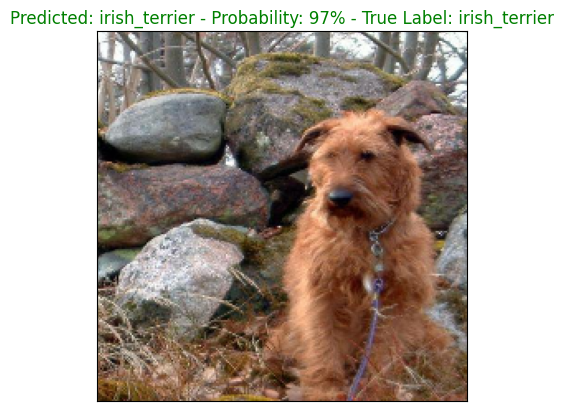

In [44]:
plot_pred(prediction_probabilites = predictions,
          labels = val_labels,
          images = val_images,
          n = 95)

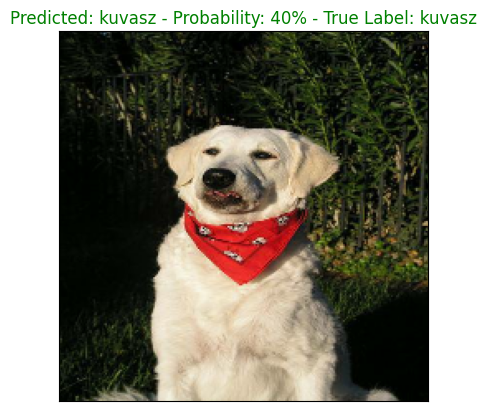

In [45]:
plot_pred(prediction_probabilites = predictions,
          labels = val_labels,
          images = val_images,
          n = 39)

In [46]:
# Create a function that visualizes the model's top 10 predictions.
def plot_pred_conf(prediction_probabilites, labels, n = 1):
  pred_prob, true_label = prediction_probabilites[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color = "grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation = "vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")


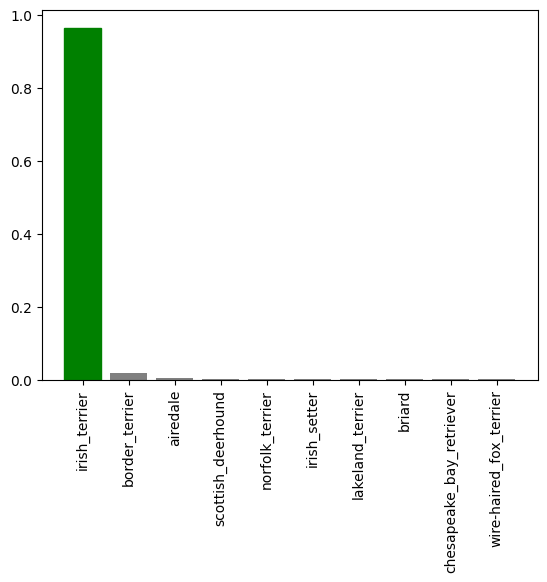

In [47]:
plot_pred_conf(prediction_probabilites = predictions,
               labels = val_labels,
               n = 95)

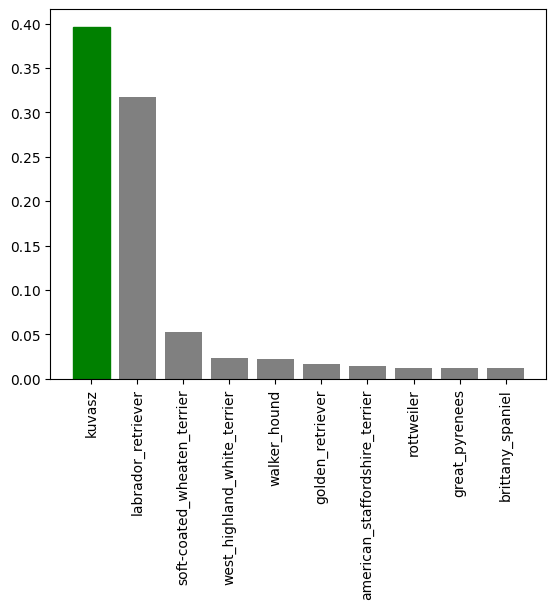

In [48]:
plot_pred_conf(prediction_probabilites = predictions,
               labels = val_labels,
               n = 39)

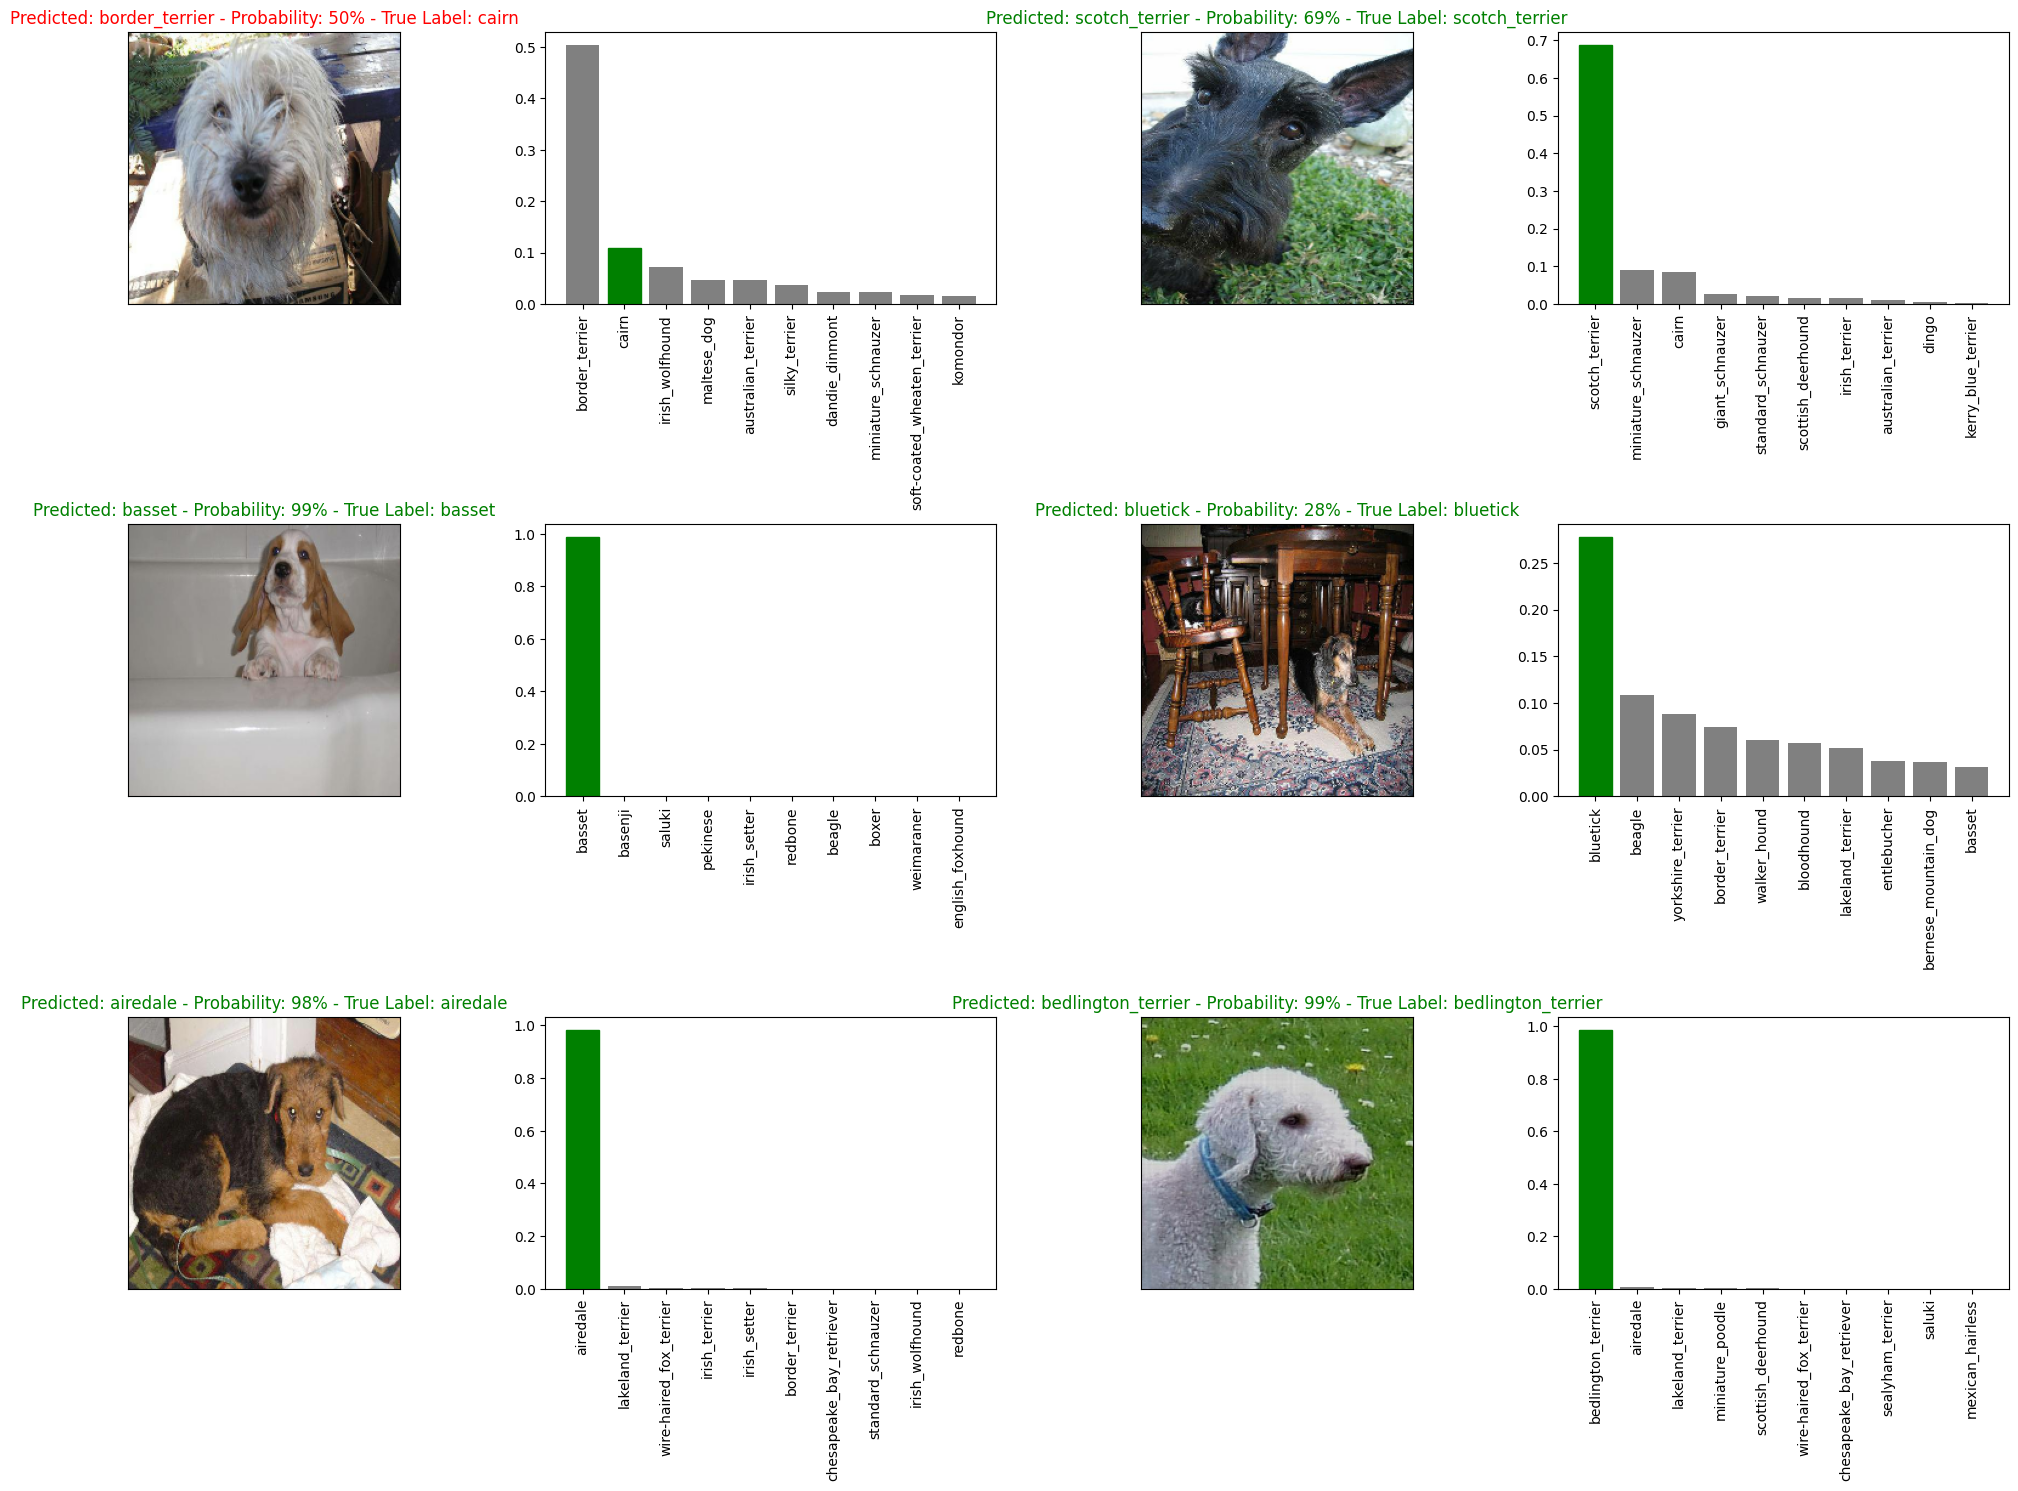

In [53]:
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize = (10 * num_cols, 5 * num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
  plot_pred(prediction_probabilites = predictions,
           labels = val_labels,
           images = val_images,
           n = i + i_multiplier)
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
  plot_pred_conf(prediction_probabilites = predictions,
           labels = val_labels,
           n = i + i_multiplier)

plt.tight_layout()
plt.show()

## Saving and reloading the trained model

In [56]:
# Create a function to save a trained model
def save_model(model, suffix = None):
  """
  Saves a given model in a models directory and appends a suffix.
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Dog Breed Identifier/models", datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))

  model_path = modeldir + "-" + suffix + ".h5" # Save format of a model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [57]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}...")
  model = tf.keras.models.load_model(model_path, custom_objects = {"KerasLayer": hub.KerasLayer})
  return model

In [58]:
# Save the model trained on 1000 images
save_model(model, suffix = "1000-images-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog Breed Identifier/models/20240422-12541713790481-1000-images-mobilenetv2-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/MyDrive/Dog Breed Identifier/models/20240422-12541713790481-1000-images-mobilenetv2-Adam.h5'

In [59]:
loaded_1000_images_model = load_model("drive/MyDrive/Dog Breed Identifier/models/20240422-12541713790481-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Dog Breed Identifier/models/20240422-12541713790481-1000-images-mobilenetv2-Adam.h5...


In [60]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 183ms/step - loss: 1.2492 - accuracy: 0.6550


[1.2491888999938965, 0.6549999713897705]

In [61]:
# Evaluate the loaded model
loaded_1000_images_model.evaluate(val_data)

7/7 [==============================] - 2s 156ms/step - loss: 1.2492 - accuracy: 0.6550


[1.2491888999938965, 0.6549999713897705]

## Training a model on the full data

In [62]:
len(X), len(y)

(10222, 10222)

In [63]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [64]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [65]:
# Create a model
full_model = create_model()

building model with: https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1


In [66]:
# Create callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so the validation accuracy can not be monitored
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "accuracy",
                                                             patience = 3)

**Note:** running the cell below will take while because the GPU has to load all the images into memory.

In [67]:
# Fit the model to the full data
full_model.fit(x = full_data,
               epochs = NUM_EPOCHS,
               callbacks = [full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 49s 135ms/step - loss: 1.3259 - accuracy: 0.6727
Epoch 2/100
320/320 [==============================] - 42s 133ms/step - loss: 0.4003 - accuracy: 0.8808
Epoch 3/100
320/320 [==============================] - 40s 126ms/step - loss: 0.2358 - accuracy: 0.9354
Epoch 4/100
320/320 [==============================] - 41s 127ms/step - loss: 0.1542 - accuracy: 0.9620
Epoch 5/100
320/320 [==============================] - 39s 122ms/step - loss: 0.1087 - accuracy: 0.9769
Epoch 6/100
320/320 [==============================] - 39s 123ms/step - loss: 0.0785 - accuracy: 0.9855
Epoch 7/100
320/320 [==============================] - 40s 125ms/step - loss: 0.0590 - accuracy: 0.9921
Epoch 8/100
320/320 [==============================] - 40s 126ms/step - loss: 0.0461 - accuracy: 0.9942
Epoch 9/100
320/320 [==============================] - 40s 125ms/step - loss: 0.0373 - accuracy: 0.9952
Epoch 10/100
320/320 [==============================] - 43s 135m

In [68]:
save_model(full_model, suffix = "full-image-set-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog Breed Identifier/models/20240422-13241713792295-full-image-set-mobilenetv2-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/MyDrive/Dog Breed Identifier/models/20240422-13241713792295-full-image-set-mobilenetv2-Adam.h5'

In [69]:
loaded_full_model = load_model("drive/MyDrive/Dog Breed Identifier/models/20240422-13241713792295-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Dog Breed Identifier/models/20240422-13241713792295-full-image-set-mobilenetv2-Adam.h5...


## Making predictions on the test dataset

In [70]:
# Load test image filenames
test_path = "drive/MyDrive/Dog Breed Identifier/test/"
test_filenames = [test_path + filename for filename in os.listdir(test_path)]
test_filenames[:10]

['drive/MyDrive/Dog Breed Identifier/test/e7be7b911a4cba9fdfa4105ec4776370.jpg',
 'drive/MyDrive/Dog Breed Identifier/test/e7ce78e874945f182a4f5149aa505b09.jpg',
 'drive/MyDrive/Dog Breed Identifier/test/e7dc8cc599049ea9fa2a172c88646c57.jpg',
 'drive/MyDrive/Dog Breed Identifier/test/e7e9624f2a2e61ab187358f5968bfde8.jpg',
 'drive/MyDrive/Dog Breed Identifier/test/e7e9dd51302fe08c1c89a550e183cf07.jpg',
 'drive/MyDrive/Dog Breed Identifier/test/e7ed96b272013c6de9505a753816ce75.jpg',
 'drive/MyDrive/Dog Breed Identifier/test/e7f95aabf775a636b3893ffa120adaf9.jpg',
 'drive/MyDrive/Dog Breed Identifier/test/e7fcdf9671a6593b638cbee42842f981.jpg',
 'drive/MyDrive/Dog Breed Identifier/test/e7feb64da6aae1ef8e62453f6660d0c5.jpg',
 'drive/MyDrive/Dog Breed Identifier/test/e800b6c8d2904e205d67ada800907762.jpg']

In [71]:
len(test_filenames)

10357

In [72]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data = True)

Creating test data batches...


In [73]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note:** running the cell below will take while for processing the images.

In [74]:
# Make predictions on the test data using the loaded model
test_predictions = loaded_full_model.predict(test_data, verbose = 1)

324/324 [==============================] - 2831s 9s/step


In [76]:
# Save predictions (NumPy Array) to csv file
np.savetxt("drive/MyDrive/Dog Breed Identifier/preds_array.csv", test_predictions, delimiter = ",")

In [78]:
# Load predictions (NumPy Array) from csv file
pred_array = np.loadtxt("drive/MyDrive/Dog Breed Identifier/preds_array.csv", delimiter = ",")

In [79]:
pred_array.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

It is required for the model's predictions to be in csv file with an ID and a column for each different breed.

www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

In [81]:
preds_df = pd.DataFrame(columns = (["id"] + list(unique_breeds)))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [84]:
# Append the IDs for the test images to the prediction dataframe
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
test_ids[:5]

['e7be7b911a4cba9fdfa4105ec4776370',
 'e7ce78e874945f182a4f5149aa505b09',
 'e7dc8cc599049ea9fa2a172c88646c57',
 'e7e9624f2a2e61ab187358f5968bfde8',
 'e7e9dd51302fe08c1c89a550e183cf07']

In [86]:
preds_df["id"] = test_ids
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e7be7b911a4cba9fdfa4105ec4776370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e7ce78e874945f182a4f5149aa505b09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e7dc8cc599049ea9fa2a172c88646c57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e7e9624f2a2e61ab187358f5968bfde8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e7e9dd51302fe08c1c89a550e183cf07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# Add the prediction probabiliess to each dog breed column
preds_df[list(unique_breeds)] = pred_array
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e7be7b911a4cba9fdfa4105ec4776370,2.253842e-07,5.518807e-06,8.307441e-08,1.442965e-07,7.312138e-10,1.480954e-09,2.283135e-10,1.132539e-09,9.897813e-10,...,2.827450e-09,3.898055e-12,1.196333e-11,4.013055e-09,3.256588e-11,1.370290e-11,6.839244e-10,7.134439e-08,2.529698e-10,2.199818e-07
1,e7ce78e874945f182a4f5149aa505b09,4.307528e-07,3.121723e-10,3.922103e-06,3.259355e-14,8.340837e-10,4.024839e-08,6.944076e-09,3.359524e-09,8.959196e-12,...,4.476900e-07,1.421137e-09,2.628299e-09,1.124799e-11,2.184960e-08,3.174869e-11,1.773897e-09,2.102998e-09,3.954555e-09,6.606063e-07
2,e7dc8cc599049ea9fa2a172c88646c57,1.436051e-06,3.652982e-08,4.922321e-09,2.231858e-10,2.146524e-07,1.741138e-08,1.270495e-09,8.931721e-09,4.257543e-12,...,1.824454e-07,1.028217e-08,3.401259e-09,2.090023e-08,7.920632e-09,9.308442e-10,3.580351e-07,1.199340e-10,7.994899e-07,1.628122e-07
3,e7e9624f2a2e61ab187358f5968bfde8,3.828544e-09,5.043822e-11,2.287195e-10,5.367776e-12,1.857589e-08,7.262681e-09,1.829917e-12,2.831668e-09,2.684572e-09,...,2.044115e-09,4.535958e-09,1.756256e-08,9.678912e-10,7.764844e-11,2.611689e-07,2.768087e-10,1.082447e-10,1.333107e-10,3.346787e-10
4,e7e9dd51302fe08c1c89a550e183cf07,4.312858e-05,2.337489e-08,7.163474e-10,1.705736e-08,2.076152e-08,2.437822e-09,7.633290e-03,2.863083e-08,1.963449e-10,...,3.424518e-08,2.920485e-04,1.177184e-09,9.653339e-11,5.538632e-09,4.374611e-10,2.185007e-06,1.414436e-08,2.111057e-06,9.915182e-01


In [89]:
# Save the prediction datafrane as CSV file for submission to Kaggle
preds_df.to_csv("drive/MyDrive/Dog Breed Identifier/full_model_predictions_submission_1_mobilenetV2.csv", index = False)